## Examples using HIF translators with HNX

Here we illustrate examples of using HNX with HIF formatted json objects. 

In [1]:
import json
import warnings

import fastjsonschema
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
warnings.simplefilter("ignore")

## Load schema and validator
The schema provides a complete description of the format and typing of an HIF json object.  
The validator is a function, which throws an error only if the object it is checking does not comply with the schema.

In [3]:
schema = json.load(open("../schemas/hif_schema_v0.1.0.json", "r"))
validator = fastjsonschema.compile(schema)

In [4]:
schema

{'$schema': 'http://json-schema.org/draft-07/schema#',
 '$id': 'https://raw.githubusercontent.com/pszufe/HIF_validators/main/schemas/hif_schema_v0.1.0.json',
 'title': 'Hypergraph Interchange Format v0.1.0',
 'type': 'object',
 'properties': {'network-type': {'enum': ['undirected', 'directed', 'asc']},
  'metadata': {'type': 'object'},
  'incidences': {'type': 'array',
   'items': {'type': 'object',
    'properties': {'edge': {'type': ['string', 'integer']},
     'node': {'type': ['string', 'integer']},
     'weight': {'type': 'number'},
     'direction': {'enum': ['head', 'tail']},
     'attrs': {'type': 'object'}},
    'unevaluatedProperties': False,
    'additionalProperties': False,
    'required': ['edge', 'node']}},
  'nodes': {'type': 'array',
   'items': {'type': 'object',
    'properties': {'node': {'type': ['string', 'integer']},
     'weight': {'type': 'number'},
     'attrs': {'type': 'object'}},
    'unevaluatedProperties': False,
    'additionalProperties': False,
    're

## Example from HyperNetX Toys

The LesMis data was developed out of the [Stanford GraphBase]( https://www-cs-faculty.stanford.edu/~knuth/sgb.html).

The hypergraph relates characters to the scenes they participate in. As scenes are indexed relative to a hierarchy, we index the hyperedges by a string of numeric indices referencing the Volume, Book, Chapter, and Scene.  

Character's are indexed by a two letter Symbol.  
Additional metadata is associated with each character including the characters fullname and description. We will incorporate this data into the hypergraph.   
Since no metadata is associated to the hyperedges, the HIF format will only include the incidences and nodes.    

In [5]:
import hypernetx as hnx
from hypernetx.utils import toys

lesmis = toys.LesMis()
lm = lesmis.hypergraph_example()
lm.nodes.dataframe.head()

/opt/anaconda3/envs/kbase/lib/python3.12/site-packages/hypernetx/utils/toys/lesmis.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.book_tour_data = self.df_scenes.groupby(["Volume", "Book"]).apply(


,weight,FullName,Description,misc_properties
uid,,,,
MY,0.56,Monsieur Charles Fran\c{c}ois Bienvenu Myriel,Bishop of D--,{'avocation': 'to be kind'}
NP,0.09,Napoleon,Emperor of France,{}
MB,0.94,Mademoiselle Baptistine,sister of MY,{}
ME,0.36,Madame Magloire,housekeeper to MY,{}
CL,0.95,Countess de Lô,distant relative of MY,{}


In [6]:
lm.incidences.dataframe.head()

weight misc_properties
edges   nodes                        
1.1.1.0 MY        0.5              {}
        NP        0.5              {}
1.1.1.1 MY        0.5              {}
        MB        0.5              {}
1.1.2.0 MY        0.5              {}

In [7]:
hnx.info_dict(lm)

{'nrows': 80,
 'ncols': 402,
 'aspect ratio': 0.19900497512437812,
 'ncells': 862,
 'density': 0.026803482587064678}

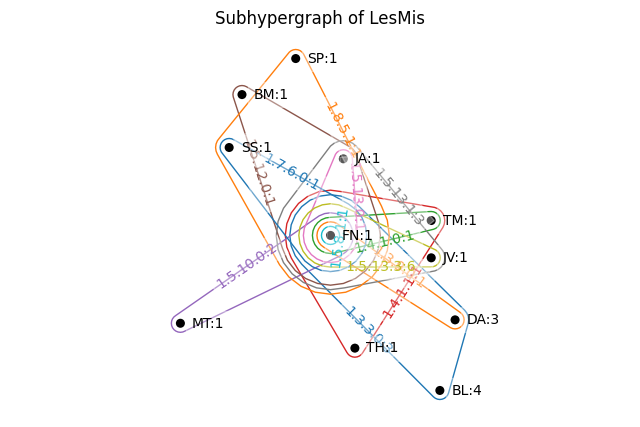

In [8]:
edges = lm.restrict_to_nodes(["FN"]).edges.items
lm_small = lm.restrict_to_edges(edges).collapse_nodes_and_edges(
    use_node_uids=["FN", "JV"], use_counts=True, return_counts=True
)
plt.title("Subhypergraph of LesMis")
plt.gcf().set_figheight(5)
hnx.draw(lm_small)

In [9]:
### View what is saved in HIF and save json to data
lesmis_hif = hnx.to_hif(lm, filename="data/lesmis.hif.json")

## The validator confirms the json read conforms to the HIF standard
output = validator(lesmis_hif)

print("metadata: ", output["metadata"], "\n")
print("network-type: ", output["network-type"])

metadata:  {'default_attrs': {'nodes': {'weight': 1, 'FullName': None, 'Description': None, 'attrs': {}}, 'edges': {'weight': 1, 'attrs': {}}, 'incidences': {'weight': 1, 'attrs': {}}}, 'name': 'LesMis example from HNX'} 

network-type:  undirected


In [10]:
## Retrieve the hypergraph from HIF
h = hnx.from_hif(filename="data/lesmis.hif.json")
hnx.info_dict(h)

{'nrows': 80,
 'ncols': 402,
 'aspect ratio': 0.19900497512437812,
 'ncells': 862,
 'density': 0.026803482587064678}

In [11]:
h.nodes.dataframe.head()

,weight,Description,FullName,misc_properties
uid,,,,
MY,0.56,Bishop of D--,Monsieur Charles Fran\c{c}ois Bienvenu Myriel,{'avocation': 'to be kind'}
NP,0.09,Emperor of France,Napoleon,{}
MB,0.94,sister of MY,Mademoiselle Baptistine,{}
ME,0.36,housekeeper to MY,Madame Magloire,{}
CL,0.95,distant relative of MY,Countess de Lô,{}


# Example Publications Dataset

This dataset consists of open source publications with the keyword "Hypergraph" and was collected from ArXiv, Biorxiv, DBLP and Osti. The Hypergraph has hyperedges as publications and nodes as authors.

In [14]:
H = hnx.from_hif(filename = 'data/publications.hif.json')

In [19]:
print('number of (nodes, edges):', H.shape)

number of (nodes, edges): (1960, 533)


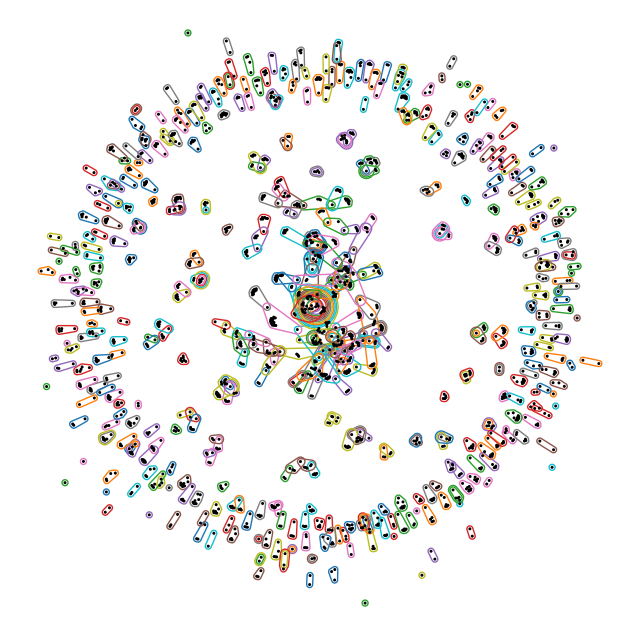

In [28]:
hnx.draw(H, with_edge_labels = False, with_node_labels = False, node_radius = 0.2, edges_kwargs = {'lw': 0.5})
plt.show()

In [128]:
# Getting the main connected component of hypergraph
import numpy as np
Hs = list(H.s_component_subgraphs(s = 1, return_singletons = False))
I = np.argsort([len(H_CC.incidences.dataframe) for H_CC in Hs])
Hs = [Hs[i] for i in I]
H_MC = Hs[-1]

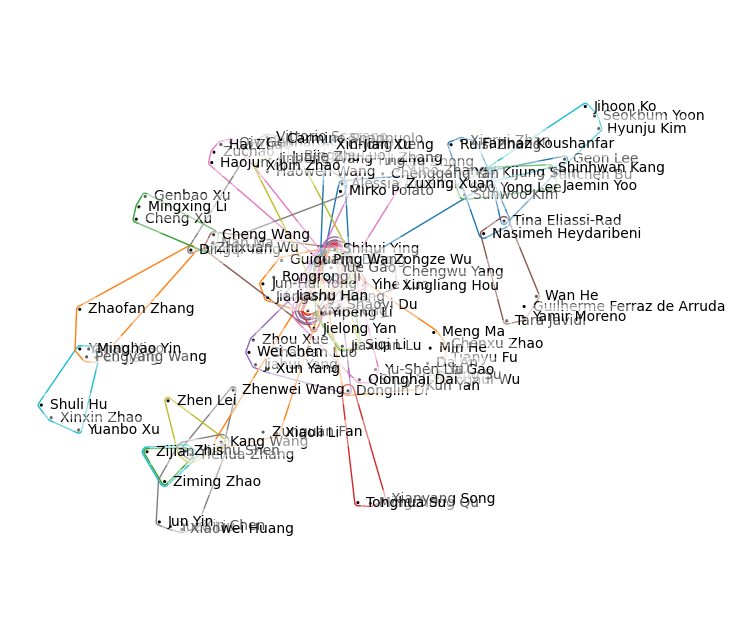

In [129]:
hnx.draw(H_MC, with_edge_labels = False, with_node_labels = True, node_radius = 0.2, edges_kwargs = {'lw': 0.5})
plt.show()

## Examples contributed from XGI data


### Contact High School
Contact-High-School originally sourced from:
https://www.cs.cornell.edu/~arb/data/contact-high-school/

This example is already in json form, but not in the HIF standard. We construct an HNX hypergraph from the json, incorporating all data, then store it in HIF.

In [12]:
chs = json.load(open("data/contacts-high-school-not-hif.json", "r"))
chs.keys()

dict_keys(['nodes', 'hyperedges'])

In [13]:
### Create a nodes dataframe with all of the properties
chsnodes = pd.DataFrame(chs["nodes"])
chsnodes = chsnodes.set_index("id").reset_index()
chsnodes

,id,class,has_facebook,has_compiled_questionnaire,facebook_friends,sex,questionnaire_friends
0,454,MP,True,False,"[34, 151, 156, 159, 866, 640, 1232]",F,NaN
1,640,MP,True,False,"[151, 159, 454]",M,NaN
2,1,2BIO3,True,True,"[883, 132, 339, 653, 545, 171, 117, 196, 587, ...",M,"[205, 272, 494, 779, 894]"
3,939,2BIO3,True,False,"[1, 55, 101, 106, 117, 119, 122, 132, 156, 170...",M,NaN
4,185,PC*,False,False,NaN,M,NaN
...,...,...,...,...,...,...,...
322,34,MP,True,True,"[20, 513, 1332, 502, 454, 1870, 201, 245, 387,...",Unknown,"[277, 502, 866]"
323,239,2BIO2,False,False,NaN,F,NaN
324,62,2BIO1,True,False,"[428, 425, 544, 122, 275]",F,NaN
325,452,PSI*,True,True,"[20, 34, 151, 156, 246, 387, 440, 691, 513, 86...",M,"[634, 691, 869, 1332]"


In [14]:
## Create an incidences datafame with timestamps included
chsinc = (
    pd.DataFrame(chs["hyperedges"])
    .reset_index()
    .rename(columns={"index": "edge", "interaction": "node"})
)
df = (
    chsinc["node"]
    .explode()
    .reset_index()
    .rename(columns={"index": "edge", "interaction": "node"})
)
df["time"] = [chsinc.loc[row.edge].time for row in df.itertuples()]

In [15]:
chsinc.head(n=10)

,edge,node,time
0,0,"[454, 640]",1385982020
1,1,"[1, 939]",1385982020
2,2,"[185, 258]",1385982020
3,3,"[9, 45]",1385982020
4,4,"[9, 453]",1385982020
5,5,"[265, 494]",1385982020
6,6,"[376, 638]",1385982020
7,7,"[14, 190]",1385982020
8,8,"[400, 637]",1385982020
9,9,"[255, 275]",1385982020


In [16]:
chshyp = hnx.Hypergraph(
    df, node_properties=chsnodes, name="contacts-high-school from XGI"
)

In [17]:
# %%time
# CPU times: user 27.7 s, sys: 259 ms, total: 27.9 s
# Wall time: 28 s

hif = hnx.to_hif(chshyp, filename="../tutorials/data/contacts_high_school.hif.json")
hif["metadata"]

{'default_attrs': {'nodes': {'weight': 1,
   'class': None,
   'has_facebook': None,
   'has_compiled_questionnaire': None,
   'facebook_friends': None,
   'sex': None,
   'questionnaire_friends': None,
   'attrs': {}},
  'edges': {'weight': 1, 'attrs': {}},
  'incidences': {'weight': 1, 'time': None, 'attrs': {}}},
 'name': 'contacts-high-school from XGI'}

In [18]:
hnx.info_dict(chshyp)

{'nrows': 327,
 'ncols': 172035,
 'aspect ratio': 0.0019007760048827273,
 'ncells': 352718,
 'density': 0.0062699352924859095}

In [19]:
# %time
# CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 μs
# Wall time: 2.86 μs

H = hnx.from_hif(filename="../tutorials/data/contacts_high_school.hif.json")
H.nodes.dataframe.head()

,weight,has_facebook,class,sex,facebook_friends,questionnaire_friends,has_compiled_questionnaire,misc_properties
uid,,,,,,,,
454,1,True,MP,F,"[34, 151, 156, 159, 866, 640, 1232]",NaN,False,{}
640,1,True,MP,M,"[151, 159, 454]",NaN,False,{}
1,1,True,2BIO3,M,"[883, 132, 339, 653, 545, 171, 117, 196, 587, ...","[205, 272, 494, 779, 894]",True,{}
939,1,True,2BIO3,M,"[1, 55, 101, 106, 117, 119, 122, 132, 156, 170...",NaN,False,{}
185,1,False,PC*,M,NaN,NaN,False,{}


### e-coli

In [21]:
H = hnx.from_hif(filename="../tutorials/data/e-coli.json")
H.edges.dataframe.head()

,weight,misc_properties
uid,,
PFK,1,{'name': 'Phosphofructokinase'}
PFL,1,{'name': 'Pyruvate formate lyase'}
PGI,1,{'name': 'Glucose-6-phosphate isomerase'}
PGI_reverse,1,{'name': 'Glucose-6-phosphate isomerase'}
PGK,1,{'name': 'Phosphoglycerate kinase'}


In [22]:
H.name

'e_coli_core'

### email-enron

In [23]:
H = hnx.from_hif(filename="../tutorials/data/email-enron.json")
H.name

'email-Enron'

In [24]:
H.nodes.dataframe.head()

,weight,misc_properties
n74,1,{'name': 'thomas.martin@enron.com'}
n107,1,{'name': 'monique.sanchez@enron.com'}
n55,1,{'name': 'tana.jones@enron.com'}
n12,1,{'name': 'rick.buy@enron.com'}
n13,1,{'name': 'larry.campbell@enron.com'}


In [25]:
H.edges.dataframe.head()

,weight,misc_properties
e3598,1,{'timestamp': '2001-10-03T22:18:19'}
e1365,1,{'timestamp': '2001-01-05T11:02:00'}
5314,1,{}
e2239,1,{'timestamp': '2001-12-07T20:30:06'}
5600,1,{}


(array([1.017e+04, 6.290e+02, 5.300e+01, 2.800e+01, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 1. ,  4.6,  8.2, 11.8, 15.4, 19. , 22.6, 26.2, 29.8, 33.4, 37. ]),
 <BarContainer object of 10 artists>)

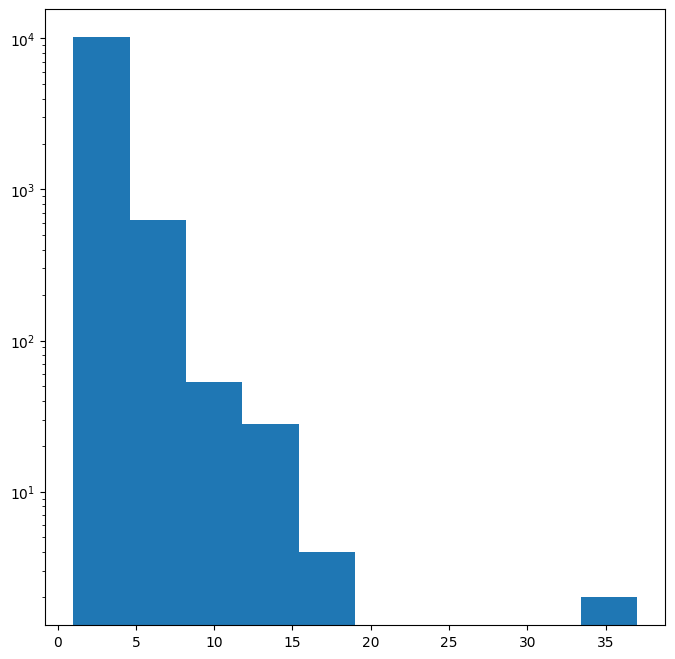

In [26]:
plt.hist(hnx.edge_size_dist(H), log=True)